<a href="https://colab.research.google.com/github/marrocrod/flyability/blob/main/probe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0.- T4 GPU Runtime Enviroment

⚠️ Make sure that you select T4 GPU in the Colab options:

      Runtime -> Runtime Enviroment -> T4 GPU

#1.- Setup

Run the following cell to install the necessary software

In [ ]:
!pip install torch torchvision albumentations opencv-python-headless matplotlib pycocotools ultralytics scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 13.3 MB/s eta 0:00:00


#2.- YOLOv5 installation

Run the following cell in order to clone the YOLOv5 git repository to work with this system and install the necessary requirements.

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 17088, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 17088 (delta 23), reused 7 (delta 7), pack-reused 17051 (from 3)
Receiving objects: 100% (17088/17088), 15.70 MiB | 15.90 MiB/s, done.
Resolving deltas: 100% (11728/11728), done.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


Now we move to the yolov5 directory and install the requirements

In [ ]:
%cd yolov5
!pip install -r requirements.txt

/content/yolov5


#3. Data



First, we have to delete the sample images from the folder **images**

In [ ]:
!rm -rf data/images/*

Add the images to the path

    yolov5/data/images

And the file with the labels to

    yolov5/data

Extract the information from the images and annotations

In [ ]:
import os

#Verify the content of the paths
print("Files in the images directory:")
print(os.listdir('data/images/'))

print("\nFiles in the lables directory:")
print(os.listdir('data/'))

Files in the images directory:
['E300SA23130257_00054_035_1flight_1200_0.jpg', 'E300SA23130257_00053_034_1flight_1200_0.jpg', 'E300SA23130257_00057_043_1flight_7500_0.jpg', 'E300SA23130257_00295_209_1flight_3600_2.jpg', 'EL300858804493_00184_039_1flight_3300_2.jpg', 'E300SA22440034_00447_133_1flight_900_2.jpg', 'E300SA23130257_00295_209_1flight_7500_2.jpg', 'E300SA23130257_00057_043_1flight_5100_0.jpg', 'EL300858804493_00184_039_1flight_1500_2.jpg', 'EL300858804493_00184_039_1flight_2700_2.jpg', 'E300SA22440034_00452_136_1flight_2100_2.jpg', 'E300SA22440035_01533_862_1flight_900_0.jpg', 'E300PREMP00002_00727_218_1flight_9600_2.jpg', 'E300SA23130257_00301_214_1flight_900_0.jpg', 'E300SA22440035_01533_862_1flight_1500_0.jpg', 'E300SA23130257_00267_199_1flight_900_2.jpg', 'EL300858804493_00330_112_1flight_8400_2.jpg', 'EL300858804493_00193_048_1flight_900_0.jpg', 'E300SA22440034_00465_143_1flight_1200_2.jpg', 'E300SA22440035_01510_843_1flight_5100_0.jpg', 'E300SA22440035_01510_843_1flight

In [ ]:
import json

# Load JSON
with open('data/probe_labels.json') as f:
    data = json.load(f)

# Extract information from the images and annonations
images = {img["id"]: img["file_name"] for img in data["images"]}
annotations = data["annotations"]

# View details
print(f"Total images: {len(images)}")
print(f"Total annotations: {len(annotations)}")
print("\nImage example:", list(images.items())[:1])
print("\nAnnotation example:", annotations[:1])

Total images: 308
Total annotations: 308

Image example: [(251, 'E300SA22440034_00465_143_1flight_13800_2.jpg')]

Annotation example: [{'bbox': [90.0, 0.0, 133.0, 208.0], 'image_id': 0}]


Split the data in training and validation

In [ ]:
from sklearn.model_selection import train_test_split

# Images IDs
image_ids = list(images.keys())

# Divide in 80% train 20% val
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

# Create list of annotations by IDs
train_annotations = [ann for ann in annotations if ann['image_id'] in train_ids]
val_annotations = [ann for ann in annotations if ann['image_id'] in val_ids]

print(f"Total training images: {len(train_ids)}")
print(f"Total validation images: {len(val_ids)}")

Total training images: 246
Total validation images: 62


In [ ]:
import os
import shutil
from PIL import Image

# Create directories for the images and labels
os.makedirs('data/train/images', exist_ok=True)
os.makedirs('data/train/labels', exist_ok=True)
os.makedirs('data/val/images', exist_ok=True)
os.makedirs('data/val/labels', exist_ok=True)

def save_labels(annotations, output_dir, images_dir, set_type):
    for ann in annotations:
        img_id = ann['image_id']
        bbox = ann['bbox']

        # Get the name of the image and the route
        img_name = images[img_id]  # Dict maps IDs to the names of the images
        img_path = os.path.join(images_dir, img_name)

        # Verify that the image exists
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue

        # Calculate the dimensions of the image
        with Image.open(img_path) as img:
            img_width, img_height = img.size

        # Calculate normalized coordinates (YOLO format)
        x, y, w, h = bbox
        x_center = (x + w / 2) / img_width
        y_center = (y + h / 2) / img_height
        norm_width = w / img_width
        norm_height = h / img_height

        # Verify that the coordinates are inside the limits
        if not (0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 <= norm_width <= 1 and 0 <= norm_height <= 1):
            print(f"Label discarded because it's outside the limits: {bbox}")
            continue

        # Create path to save the
        label_path = os.path.join(output_dir, f"{img_name.split('.')[0]}.txt")

        # Save label
        with open(label_path, 'a') as f:
            f.write(f"0 {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}\n")  # Clase 0 (sonda)

        # Move the images to it's correspondant directory
        if set_type == "train":
            shutil.copy(img_path, 'data/train/images')
        else:
            shutil.copy(img_path, 'data/val/images')

# Dict that maps the images IDs to its names
images = {img['id']: img['file_name'] for img in data['images']}  # data proviene del JSON cargado

# Save labels and move images
save_labels(train_annotations, 'data/train/labels', 'data/images', 'train')
save_labels(val_annotations, 'data/val/labels', 'data/images', 'val')


In [ ]:
yaml_content = """
train: data/train/images
val: data/val/images

nc: 1
names: ['probe']
"""

# Save file
with open('data.yaml', 'w') as f:
    f.write(yaml_content)

#4.- Model training

⚠️ First of all, before the execution you must add the file **hyp.augmentation.yaml** that you can find in the file zip to this path:

    yolov5/data/hyps

Once you have added the file, you can run the following cell in order to start the training of the model. This will take around 10-11m with the current parameters.


In [ ]:
!python train.py --img 640 --batch 32 --epochs 100 --multi-scale --hyp data/hyps/hyp.augmentation.yaml --data data.yaml --weights yolov5s.pt --optimizer AdamW --project probe_detection --name probe_experiment --cache

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-01-04 13:51:45.720692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-04 13:51:45.748636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-04 13:51:45.758550: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visua

#5.- Graphs

Run the following cells to visualize the results. You also can see a few graphs than can help to understand the training proccess and the metrics obtained.

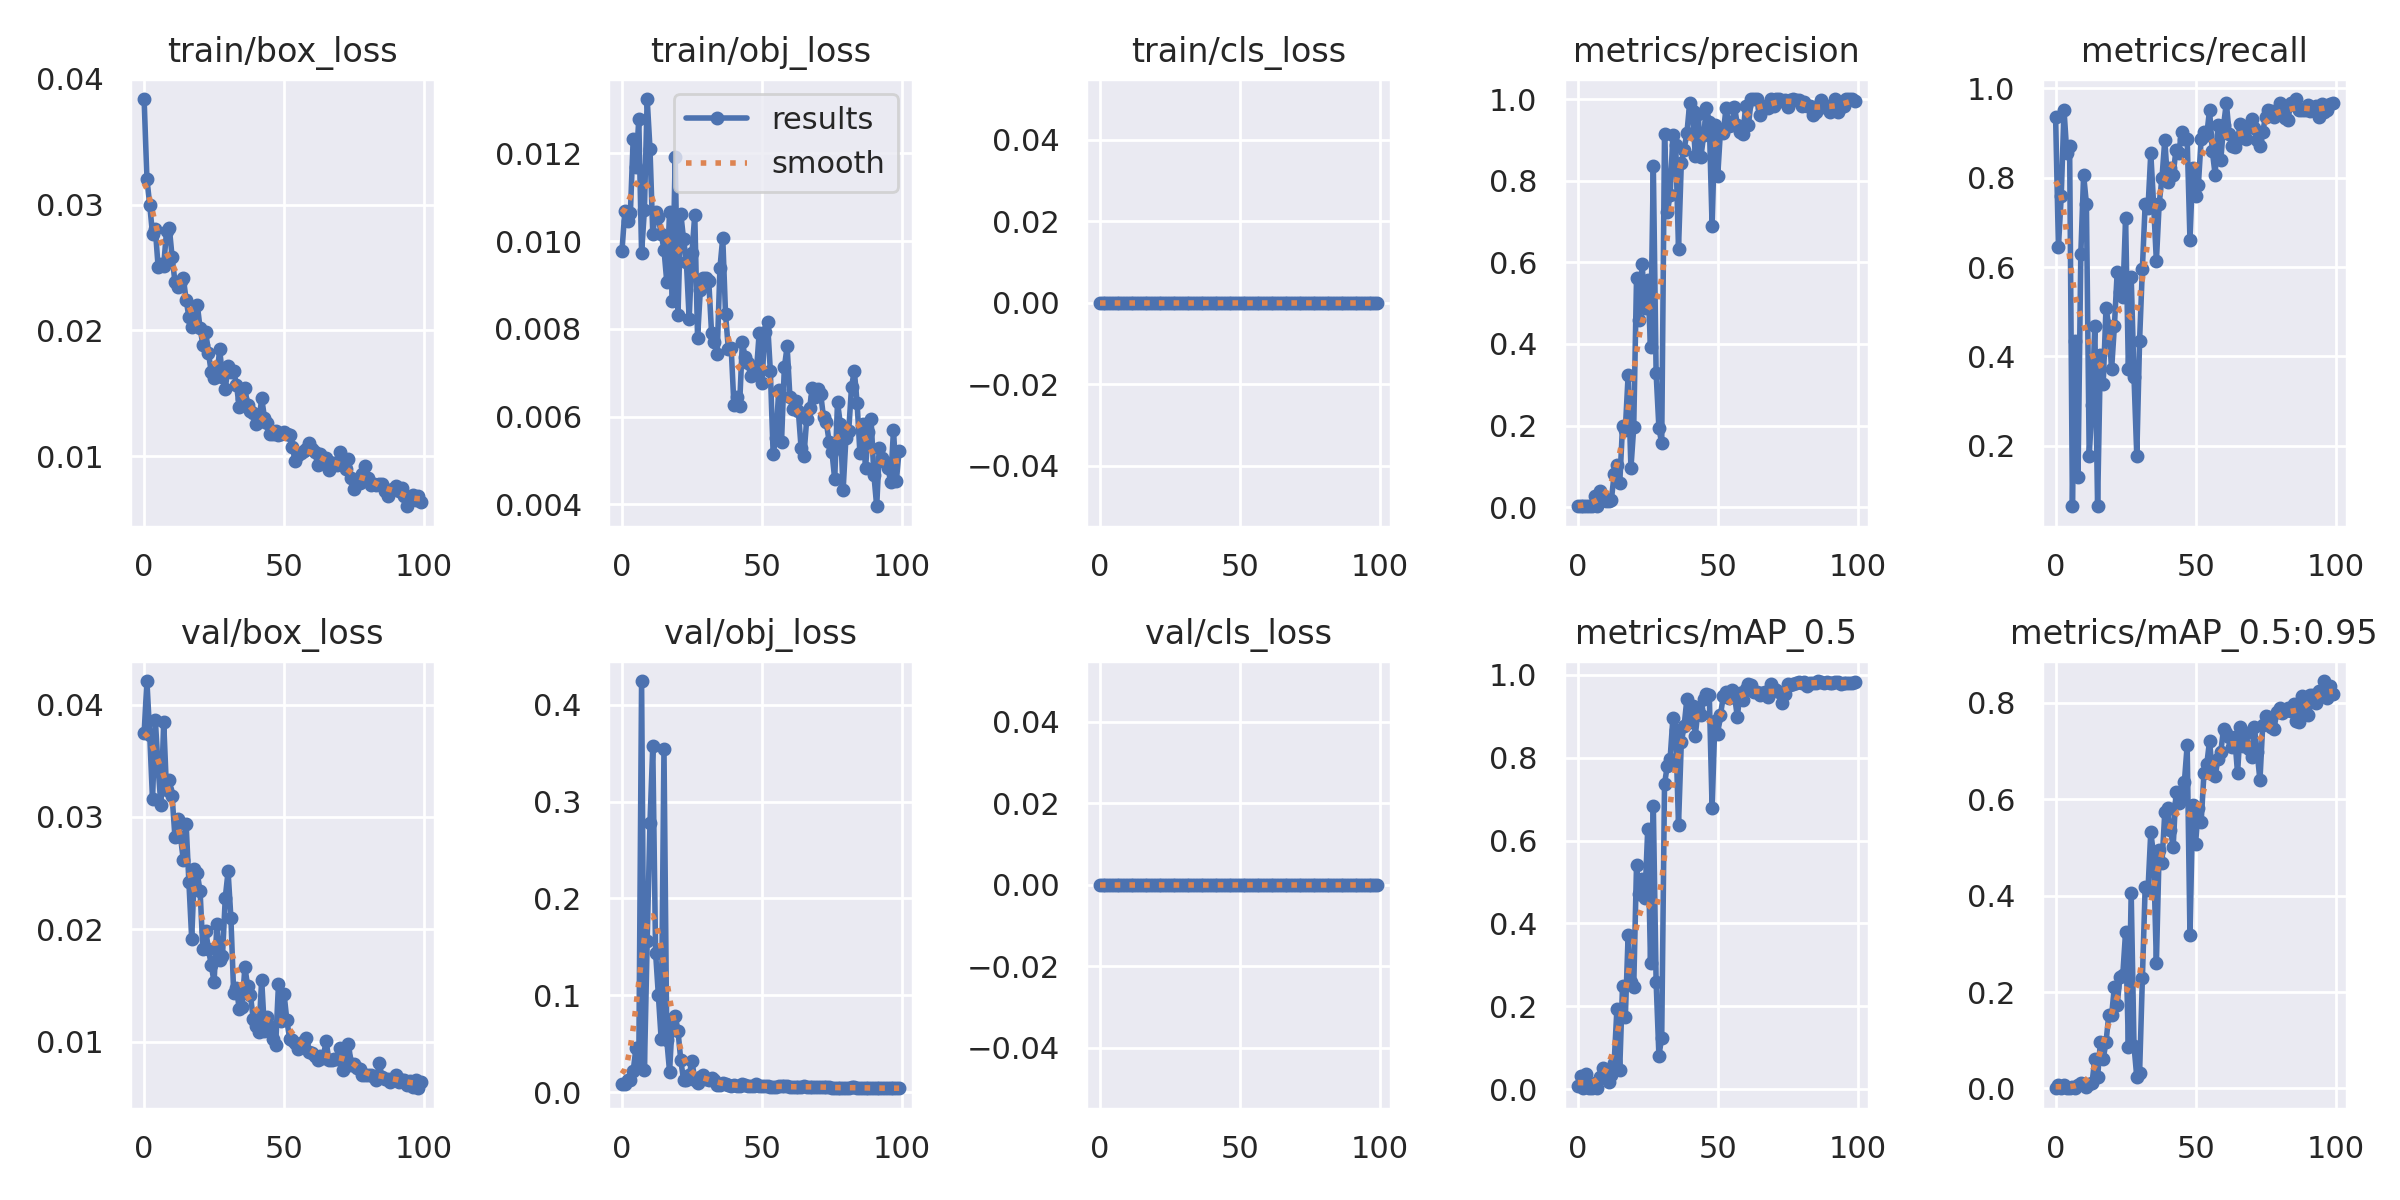

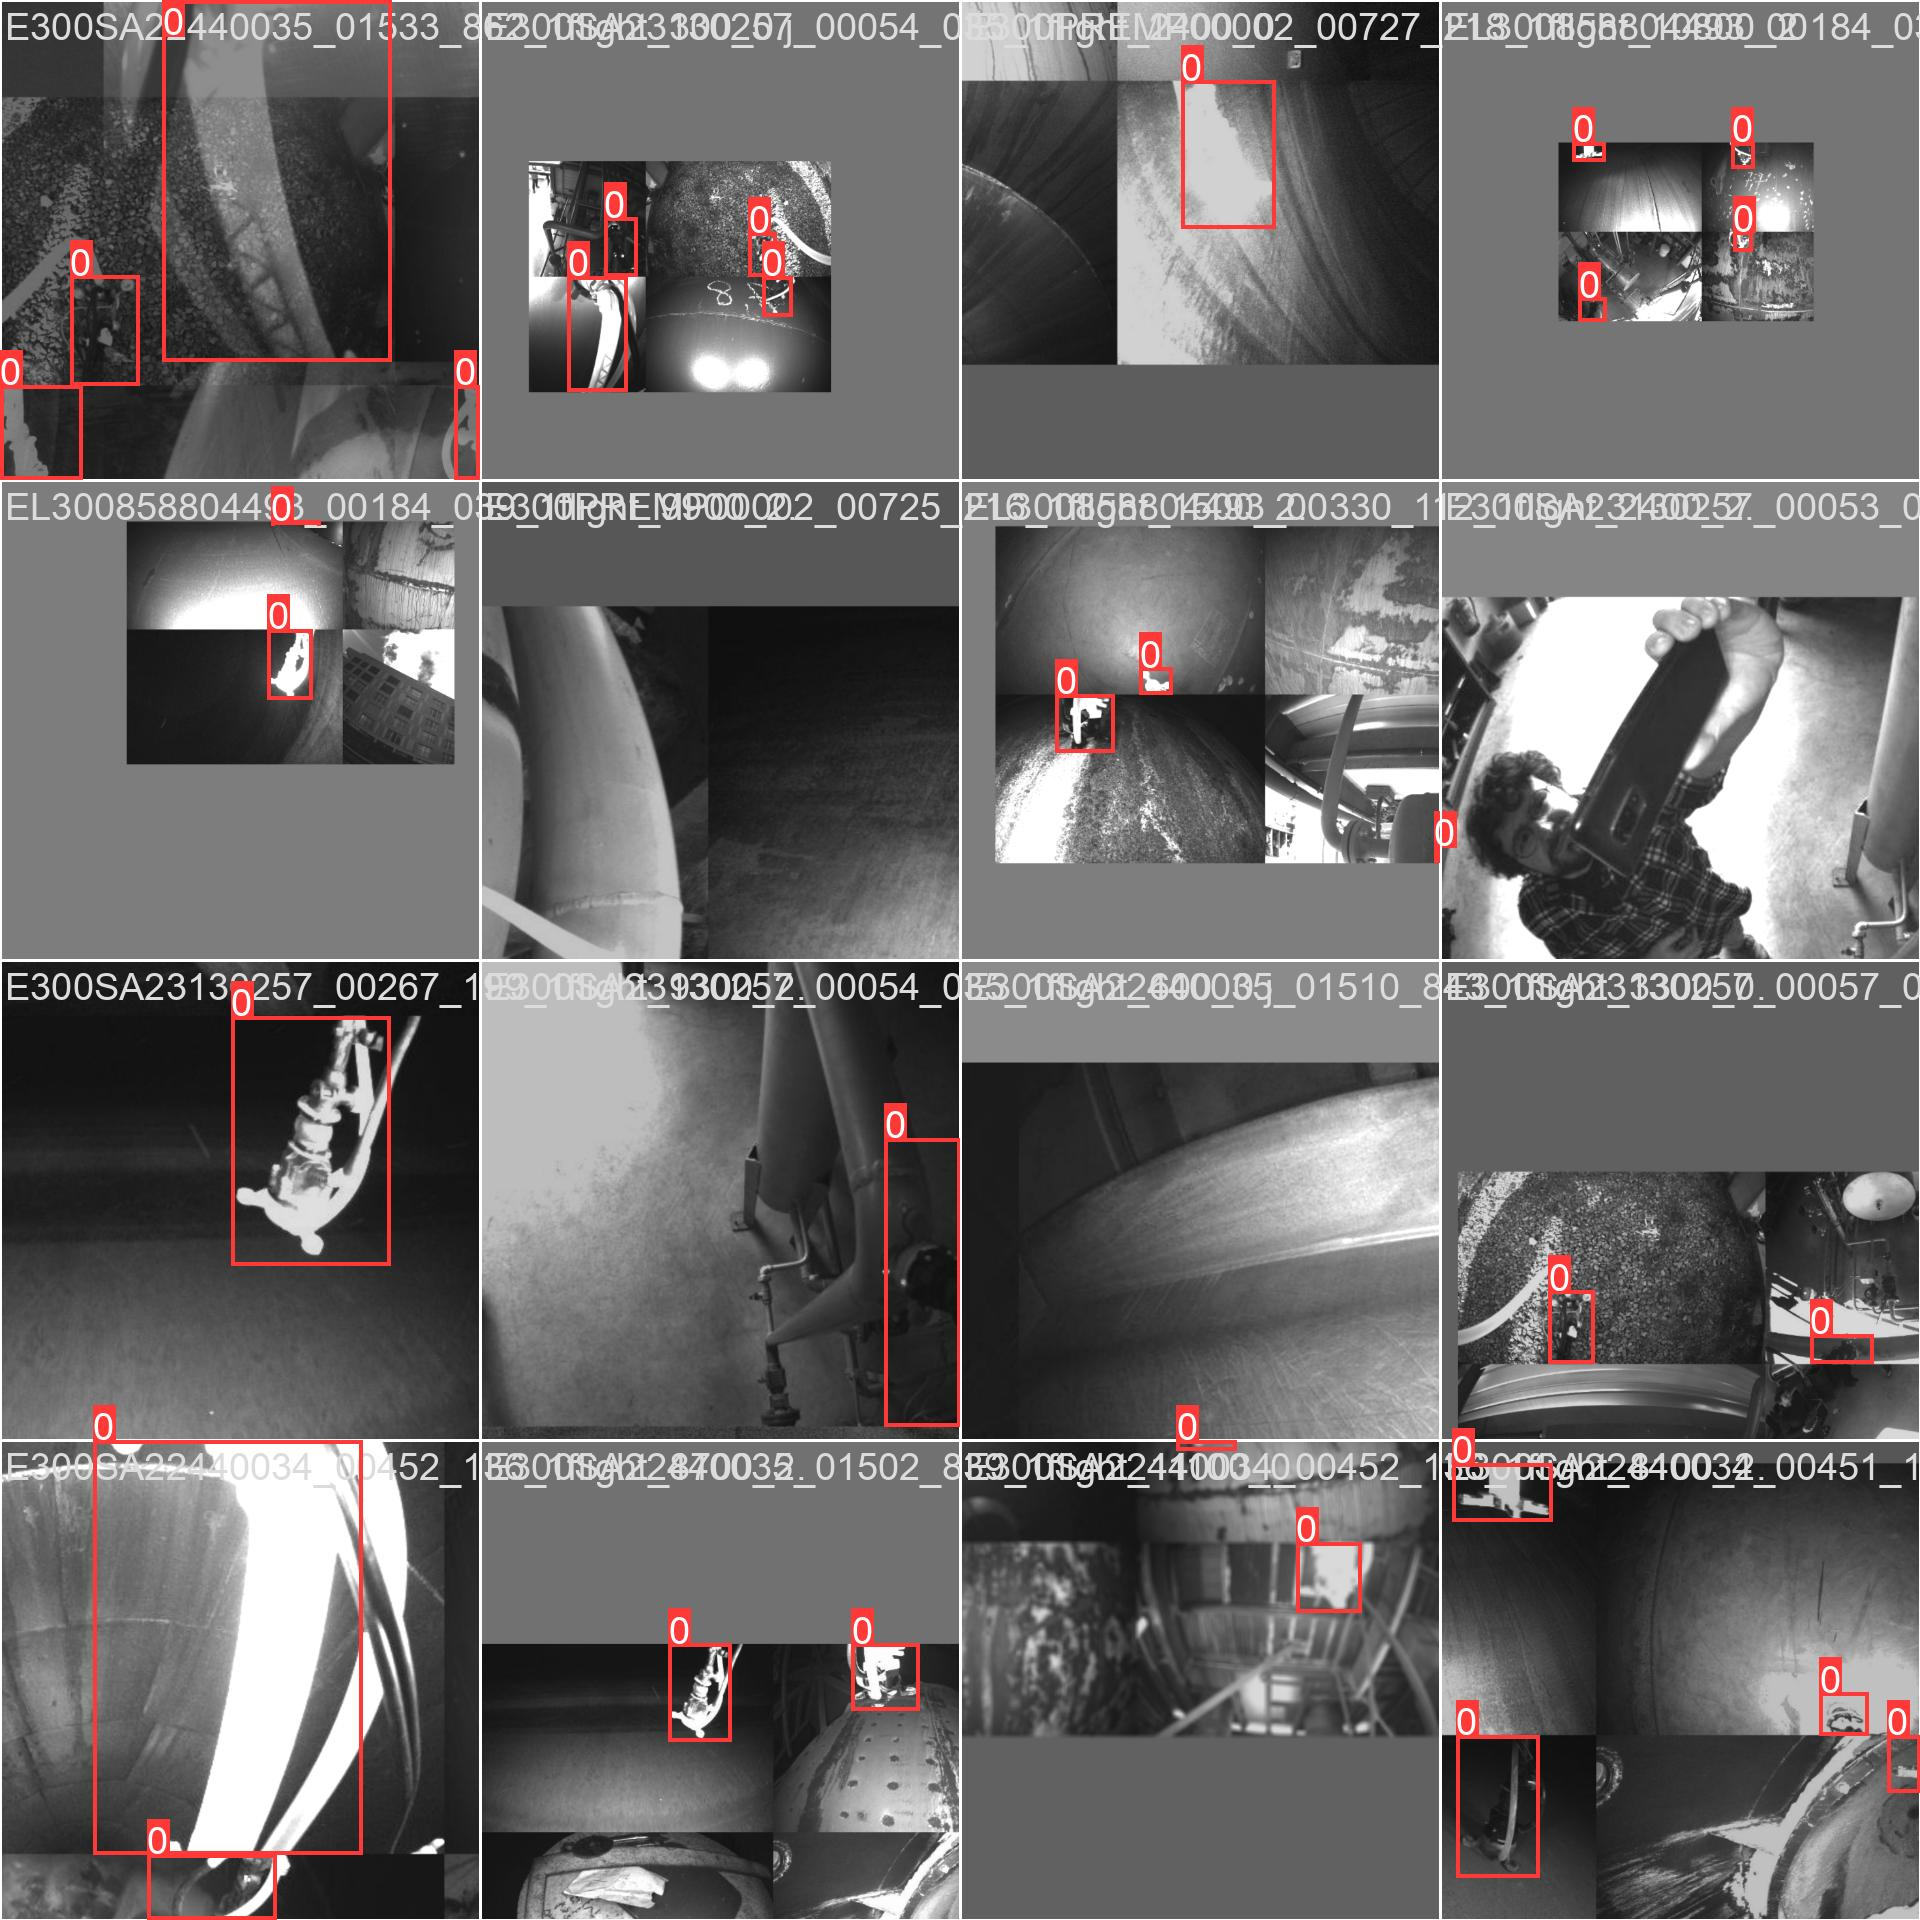

In [27]:
from IPython.display import Image, display

# Path to the directory where the graphs are saved
log_dir = 'probe_detection/probe_experiment'

# Show results graph
display(Image(filename=os.path.join(log_dir, 'results.png')))

# Show training graph
display(Image(filename=os.path.join(log_dir, 'train_batch0.jpg')))


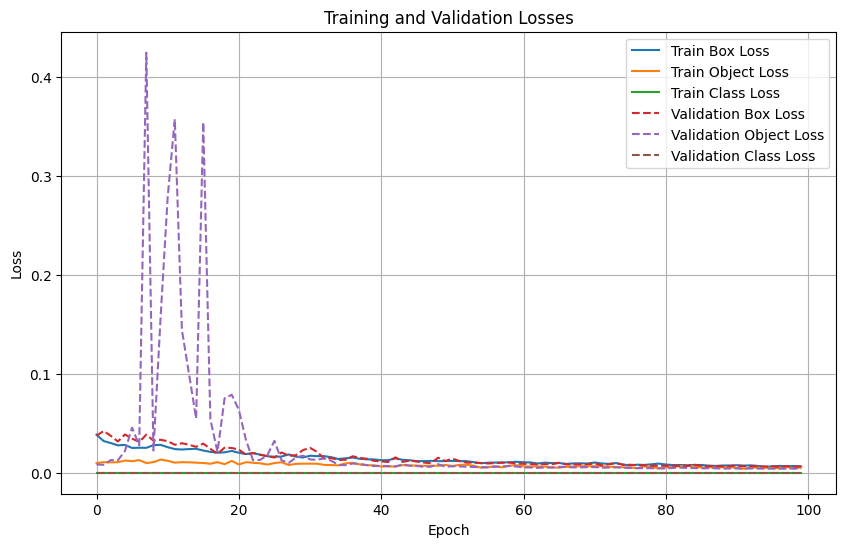

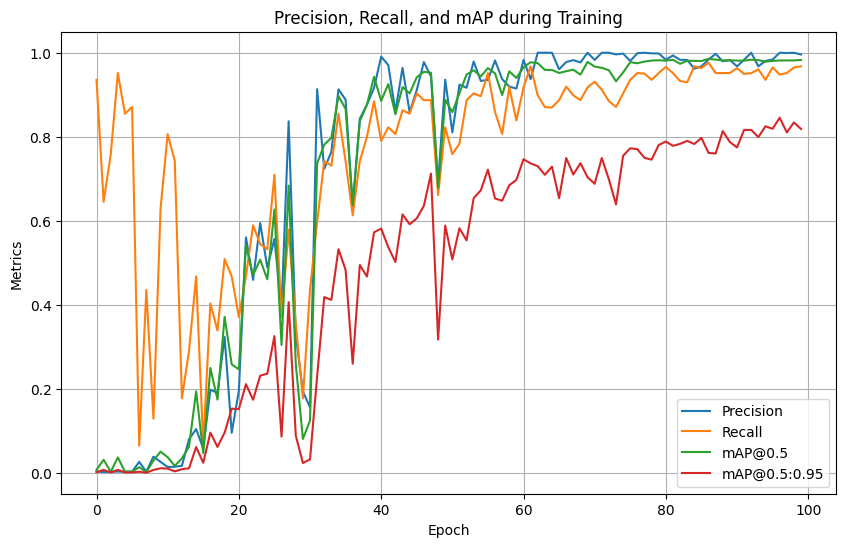

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the file of results Ruta al archivo de resultados
log_dir = 'probe_detection/probe_experiment'
results_path = os.path.join(log_dir, 'results.csv')

# Read results.csv
results = pd.read_csv(results_path)
results.columns = results.columns.str.strip()


# Loss graph
plt.figure(figsize=(10, 6))
plt.plot(results['epoch'], results['train/box_loss'], label='Train Box Loss')
plt.plot(results['epoch'], results['train/obj_loss'], label='Train Object Loss')
plt.plot(results['epoch'], results['train/cls_loss'], label='Train Class Loss')
plt.plot(results['epoch'], results['val/box_loss'], label='Validation Box Loss', linestyle='--')
plt.plot(results['epoch'], results['val/obj_loss'], label='Validation Object Loss', linestyle='--')
plt.plot(results['epoch'], results['val/cls_loss'], label='Validation Class Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()

# Metrics: Precision, Recall, mAP@0.5, mAP@0.5:0.95
plt.figure(figsize=(10, 6))
plt.plot(results['epoch'], results['metrics/precision'], label='Precision')
plt.plot(results['epoch'], results['metrics/recall'], label='Recall')
plt.plot(results['epoch'], results['metrics/mAP_0.5'], label='mAP@0.5')
plt.plot(results['epoch'], results['metrics/mAP_0.5:0.95'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Precision, Recall, and mAP during Training')
plt.legend()
plt.grid()
plt.show()


We can check if there has been overfitting with this graph:

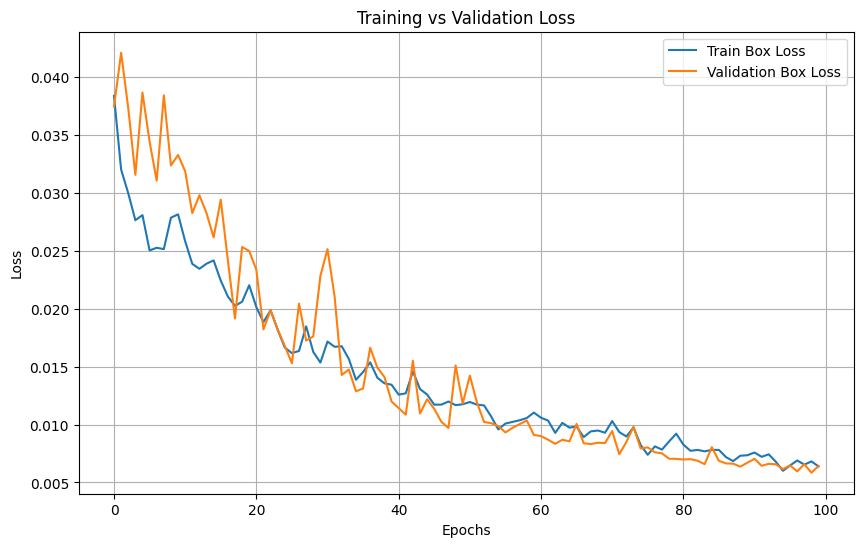

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(results['epoch'], results['train/box_loss'], label='Train Box Loss')
plt.plot(results['epoch'], results['val/box_loss'], label='Validation Box Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()
